# 03. Analysis of the Incel Communities Network made in part 02

In [ ]:
#Import relevant libraries
import networkx as nx
from netwulf import visualize, draw_netwulf
import netwulf as nw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import random
from tqdm import tqdm
import warnings  
from statistics import mean
warnings.filterwarnings("ignore", category=FutureWarning)
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity

In [3]:
# --- Load all four graphs
G_All       = nx.read_gml("data/graphs/reddit_graph.gml", label=None)
G_Braincels = nx.read_gml("data/graphs/reddit-braincels-posts.anon.gml", label=None)
G_Incel     = nx.read_gml("data/graphs/reddit-incel-posts.anon.gml", label=None)
G_IncelExit = nx.read_gml("data/graphs/reddit-IncelExit-posts.anon.gml", label=None)

In [31]:

def print_graph_info(name, G):
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    if G.is_directed():
        connected = nx.is_weakly_connected(G)
    else:
        connected = nx.is_connected(G)
    print("\n")    
    print("#" * 40)
    print(f"{name}")
    print("-" * 40)
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Density: {density:.6f}")
    print(f"Directed: {G.is_directed()}")
    print(f"Connected: {connected}")
    print(f"Amount of lonely nodes (degree 0): {len([n for n, d in G.degree() if d == 0])}")
    print("#" * 40)


print_graph_info("Reddit - All Posts", G_All)
print_graph_info("Reddit - Braincels", G_Braincels)
print_graph_info("Reddit - Incel", G_Incel)
print_graph_info("Reddit - IncelExit", G_IncelExit)




########################################
Reddit - All Posts
----------------------------------------
Nodes: 100162
Edges: 1011470
Density: 0.000202
Directed: False
Connected: False
Amount of lonely nodes (degree 0): 15942
########################################


########################################
Reddit - Braincels
----------------------------------------
Nodes: 75134
Edges: 1158035
Density: 0.000205
Directed: True
Connected: False
Amount of lonely nodes (degree 0): 7563
########################################


########################################
Reddit - Incel
----------------------------------------
Nodes: 23903
Edges: 110983
Density: 0.000194
Directed: True
Connected: False
Amount of lonely nodes (degree 0): 8645
########################################


########################################
Reddit - IncelExit
----------------------------------------
Nodes: 4003
Edges: 13931
Density: 0.000870
Directed: True
Connected: False
Amount of lonely nodes (degree 0): 52


In [ ]:
# Define simple colors for the subreddit categories
subreddit_colors = {
    'r/Incel': '#1f77b4',      # blue
    'r/Braincels': '#ff7f0e',  # orane
    'r/IncelExit':'#2ca02c' ,  # green ("the good guys")
    'unknown':  '#7f7f7f'      # gray (for missing/other)
}

# Assign colors to nodes based on their subreddit_origin attribute
for n, attrs in G_All.nodes(data=True):
    sr = attrs.get('subreddit_origin', 'unknown')
    G_All.nodes[n]['color'] = subreddit_colors.get(sr, '#cccccc')  # fallback grey

# Visualize interactively
network, config = nw.visualize(G_All, plot_in_cell_below=False)

# Optional static matplotlib plot
fig, ax = nw.draw_netwulf(network)
ax.set_title('Network of All Reddit Posts Colored by Subreddit Origin')


![](plots/networks/network_all_reddit_posts.png)

The network seems pretty clustered by subreddit origin:
- Orange nodes (r/Braincels) dominate the network, forming the main dense core.
- Blue nodes (r/Incel) appear as a distinct peripheral cluster.
- Green nodes (r/IncelExit) form a smaller, separate group, indicating limited interaction with the main communities.

Moving on with the analysis we would like to investigate whether other kinds of communities submerge in these foras.

# Baseline network - a random network to compare with

We would like to investigate the degree distribution of the network to the overall degree distribution and link probability.

In [7]:
N = G_All.number_of_nodes() 
L = G_All.number_of_edges() 

p = (2 * L) / (N * (N - 1))

#calculate the average degree using p
k = p*(N-1)
print(f'The probability (p) of a link between two nodes is: {p}')
print(f'Average degree (k) of the incelExit-network: {k}')

The probability (p) of a link between two nodes is: 0.0002016421698682182
Average degree (k) of the incelExit-network: 20.196681376170606


In [ ]:
#function to calculate generate random network:
def generate_random_network(node_count, probability):
    random_network = nx.Graph()
    nodes = range(node_count)
    random_network.add_nodes_from(nodes)

    for i in tqdm(nodes, desc="Generating network", unit="node"):
        for j in nodes:
            if i < j:
                if np.random.uniform(0, 1) < probability:
                    random_network.add_edge(i, j)

    return random_network

# Generate random network
random_network = generate_random_network(N, p)

We use network x's build in function to calculate a random network with a similar link probability and average degree because our own nested function takes too long:

In [ ]:
random_network = nx.erdos_renyi_graph(N, p)
#nx.write_gml(random_network, "data/graphs/random_network.gml")


In [25]:
# Print some information about the generated random network
print(f'The number of nodes in the random network is {random_network.number_of_nodes()} and the amount of edges are {random_network.number_of_edges()}')
print(f'The denisty of random network is {nx.density(random_network)}')
print(f'Is the graph fully connected: {nx.is_connected(random_network)}')
print(f'The average degree of the random network is {np.mean([degree for node, degree in random_network.degree()])}')

The number of nodes in the random network is 100162 and the amount of edges are 1010462
The denisty of random network is 0.00020144121946214866
Is the graph fully connected: True
The average degree of the random network is 20.17655398254827


In [ ]:
network, config = nw.visualize(random_network, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network)
ax.set_title('Random network')

![](plots/networks/random_network.png)

# Degree distribution

In [27]:
# Obtain the degrees of all nodes in the random network and CSS-network
Normal_degrees = [degree for node, degree in random_network.degree()]
Incels_degrees = [degree for node, degree in G_All.degree()]  

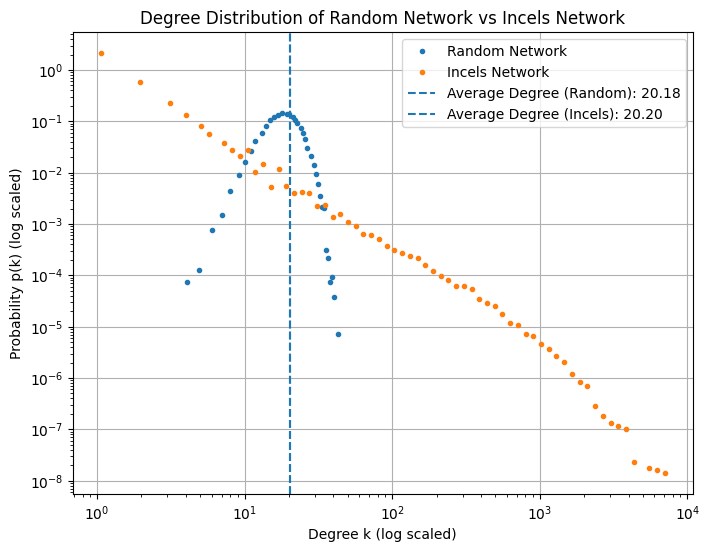

In [29]:
# Convert to arrays
Normal_degrees    = np.asarray(Normal_degrees)
Incels_degrees = np.asarray(Incels_degrees)

# Keep only positive degrees for log-binning
norm_pos  = Normal_degrees[Normal_degrees > 0]
brain_pos = Incels_degrees[Incels_degrees > 0]

if norm_pos.size == 0 or brain_pos.size == 0:
    raise ValueError("No positive-degree nodes found in one of the networks; cannot use log-scale on k=0.")

# Bins on [min_positive, max]
bins_norm  = np.logspace(np.log10(norm_pos.min()),  np.log10(norm_pos.max()),  75)
bins_brain = np.logspace(np.log10(brain_pos.min()), np.log10(brain_pos.max()), 75)

# Histograms (density=True → p(k))
hist_normal, edges_normal = np.histogram(norm_pos,  bins=bins_norm,  density=True)
hist_brain,  edges_brain  = np.histogram(brain_pos, bins=bins_brain, density=True)

# Bin centers
x_norm  = 0.5*(edges_normal[1:] + edges_normal[:-1])
x_brain = 0.5*(edges_brain[1:]  + edges_brain[:-1])

# Filter zero-density bins (log y cannot show zeros)
nz_norm  = hist_normal > 0
nz_brain = hist_brain  > 0
x_norm,  y_norm  = x_norm[nz_norm],   hist_normal[nz_norm]
x_brain, y_brain = x_brain[nz_brain], hist_brain[nz_brain]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_norm,  y_norm,  marker='.', linestyle='none', label='Random Network')
ax.plot(x_brain, y_brain, marker='.', linestyle='none', label='Incels Network')

# Average degrees (use the original arrays)
avg_degree_random = Normal_degrees.mean()
avg_degree_brain  = Incels_degrees.mean()  # Undirected graph: divide by 2
ax.axvline(avg_degree_random, linestyle='--', label=f'Average Degree (Random): {avg_degree_random:.2f}')
ax.axvline(avg_degree_brain,  linestyle='--', label=f'Average Degree (Incels): {avg_degree_brain:.2f}')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Degree k (log scaled)')
ax.set_ylabel('Probability p(k) (log scaled)')
ax.set_title('Degree Distribution of Random Network vs Incels Network')
ax.legend()
ax.grid(True)

#plt.text(0.7, 0.0, "Only a subset of the entire Reddit network",ha='center', va='bottom', transform=ax.transAxes, fontsize=8)
plt.show()


The random network shows a narrow, bell-shaped degree distribution centered around the average degree (~20), as expected.

The incel network has a heavy-tailed (also called powerlaw) distribution, with many low-degree nodes and some very high-degree hubs.

Even with the same average degree, the incel network is far more heterogeneous, indicating real social structure rather than random connectivity.

# Connected components and Average shortest paths

In [8]:
# Enumerate all connected components
connected_components = list(nx.algorithms.connected_components(G_All))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph of the original network with only the nodes in the largest component
largest_component_graph = G_All.subgraph(largest_component)

print_graph_info("Largest Connected Component - All Posts", largest_component_graph)



########################################
Largest Connected Component - All Posts
----------------------------------------
Nodes: 83970
Edges: 1011336
Density: 0.000287
Directed: False
Connected: True
Amount of lonely nodes (degree 0): 0
########################################


In [ ]:
network, config = nw.visualize(largest_component_graph, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network)
ax.set_title('Largest Connected Component of full Reddit Network')

![](plots/networks/largest_component.png)

Because the netowrk is so huge - We approximate the average shortest path length by running BFS from 1000 randomly sampled nodes and averaging all finite distances to other nodes.

In [ ]:
def approx_avg_spl(G, k=1000, seed=42):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    sample = rng.sample(nodes, min(k, len(nodes)))
    dists = []
    for s in sample:
        lengths = nx.single_source_shortest_path_length(G, s) # then we calculate the shortest path lengths from source node s to all other reachable nodes
        # drop self-distance 0
        dists.extend(d for d in lengths.values() if d > 0) # this means we only take distances greater than 0 
    return mean(dists)

approx_l = approx_avg_spl(largest_component_graph, k=1000)
print(f"The approximate aveage shortest path using a sample (N=1000) is: {approx_l}")

The approximate aveage shortest path using a sample (N=1000) is: 3.4296858245304813


In [24]:
approx_l_random = approx_avg_spl(random_network, k=1000)
print(f"The approximate aveage shortest path using a sample (N=1000) on the random network is: {approx_l_random}")

The approximate aveage shortest path using a sample (N=1000) on the random network is: 4.120352163017542


The approximate average shortest path length of 3.4 indicates that the incel network displays strong small-world properties.
Despite having nearly 84,000 users in the largest connected component, any two individuals are typically only three to four steps apart. This suggests fast potential spread of information or influence and the presence of well-connected hubs or tightly linked community cores. Which is also what could be expected of an online community like this on reddit.



# Communities

In [4]:
# --- Remove degree-0 nodes from G_All
G_non_iso = G_All.copy()
G_non_iso.remove_nodes_from(list(nx.isolates(G_non_iso)))

print("Original nodes:", G_All.number_of_nodes())
print("After removing degree-0:", G_non_iso.number_of_nodes())


Original nodes: 100162
After removing degree-0: 84220


In [6]:
louvain_comm = nx.community.louvain_communities(G_non_iso, weight="weight", seed=42)
# Compute modularity for Louvain clusters
louvain_modularity = modularity(G_non_iso, louvain_comm)
print(f"Modularity for Louvain: {louvain_modularity}")
# Print the resulting communities
print("Louvain Community Partition:")
print(f"Found {len(louvain_comm)} communities.")
print(f"Largest community size: {len(max(louvain_comm, key=len))}")
print(f"Smallest community size: {len(min(louvain_comm, key=len))}")


Modularity for Louvain: 0.4456146094416373
Louvain Community Partition:
Found 223 communities.
Largest community size: 21739
Smallest community size: 2


A modularity of 0.4456 means the graph has moderately strong, meaningful community structure, clearly better than random, but not extremely cleanly separated. 


Experimenting with the resolutions of the louvain algorithm.  Lower values (< 1) means fewer, larger communities. Higher values (> 1) means more, smaller communities.

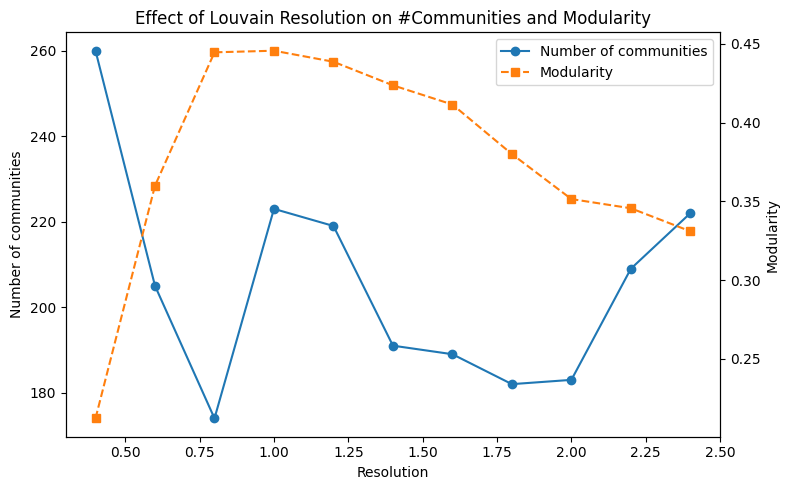

In [17]:
resolutions = np.arange(0.4, 2.6, 0.2)  
num_comms = []
mods = []
community_sizes_by_res = {}

for res in resolutions:
    comms = nx.community.louvain_communities(
        G_non_iso,
        weight="weight",
        resolution=res,
        seed=42
    )
    num_comms.append(len(comms))
    
    # store community sizes
    community_sizes_by_res[res] = [len(c) for c in comms]
    
    # compute modularity at this resolution
    m = modularity(G_non_iso, comms, weight="weight")
    mods.append(m)

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(resolutions, num_comms, marker="o", label="Number of communities")
ax1.set_xlabel("Resolution")
ax1.set_ylabel("Number of communities")

ax2 = ax1.twinx()
ax2.plot(resolutions, mods, marker="s", linestyle="--", label="Modularity", color="tab:orange")
ax2.set_ylabel("Modularity")

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.title("Effect of Louvain Resolution on #Communities and Modularity")
plt.tight_layout()
plt.show()


The modularity curve peaks around resolutions 0.75–1.0, indicating this is the graph’s most natural and meaningful scale of community structure, while higher resolutions begin to over-split communities and reduce modularity. We decide to move on with the default resolution size on 1 as this suggests the best split, and then we look into the size distribution:

The networks community structure is robust - adjusting the resolution doesn’t strongly change how many groups Louvain finds. The small rise and fall suggests the algorithm slightly refines clusters around mid-resolutions (1.0–1.5), but the overall structure remains consistent. Therefore we mowe forward with the initial partition made using resolution 1.

We print the sizes of the 6 largest communities:

In [36]:
# Compute sizes and retain original IDs
comm_sizes = [(i, len(c)) for i, c in enumerate(louvain_comm)]
comm_sizes = sorted(comm_sizes, key=lambda x: x[1], reverse=True)

# Print top 5 largest community IDs (real Louvain labels)
for rank, (comm_id, size) in enumerate(comm_sizes[:6], start=1):
    print(f"Rank {rank}: Community {comm_id} — Size {size}")

Rank 1: Community 89 — Size 21739
Rank 2: Community 129 — Size 21188
Rank 3: Community 130 — Size 17547
Rank 4: Community 191 — Size 14563
Rank 5: Community 220 — Size 5670
Rank 6: Community 188 — Size 2899


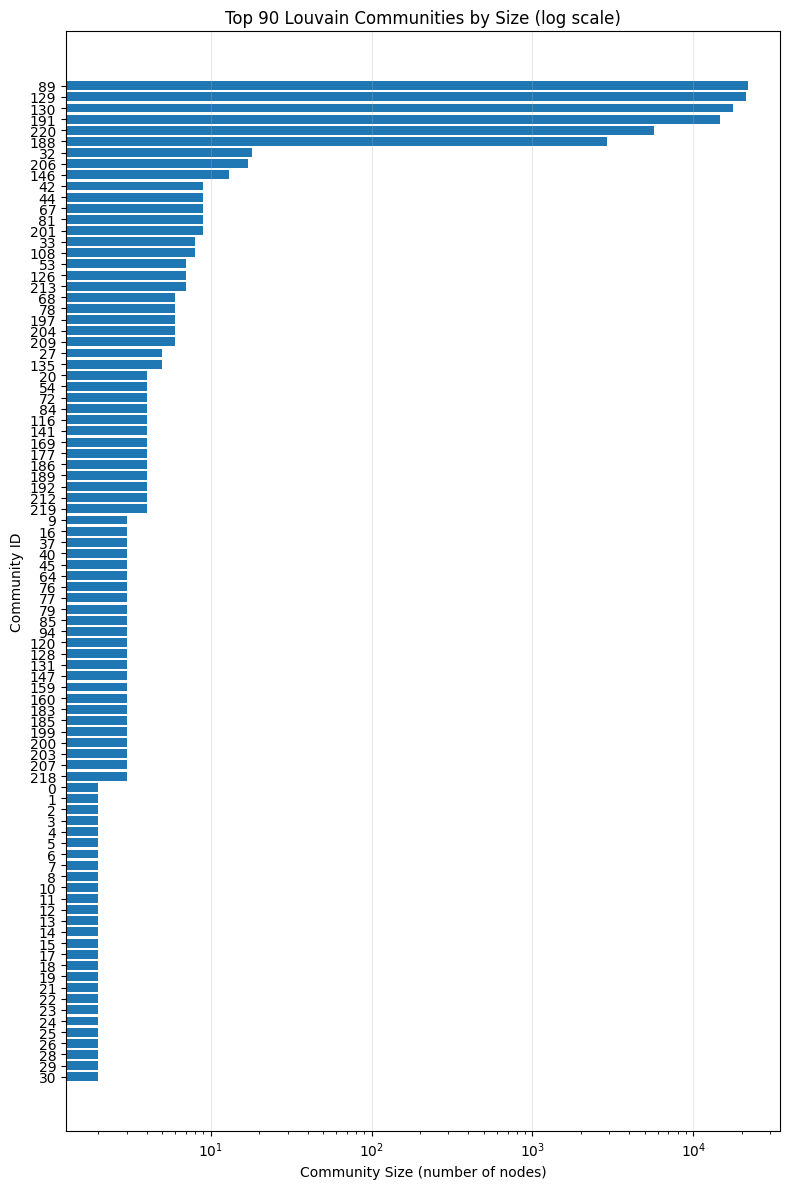

In [ ]:
import matplotlib.pyplot as plt

k = 90   # number of largest communities to show
top_comm = comm_sizes[:k]

comm_ids = [int(cid) for cid, size in top_comm]   # ensure integers
sizes    = [size for cid, size in top_comm]

plt.figure(figsize=(8, 12))

# use positions 0..k-1 on y-axis and label them with the community IDs
y_pos = range(len(comm_ids))
plt.barh(y_pos, sizes)
# log scale for x-axis
plt.xscale("log")

plt.yticks(y_pos, [str(cid) for cid in comm_ids])  # show IDs as text labels
plt.gca().invert_yaxis()  # largest community (index 0) at the top

plt.xlabel("Community Size (number of nodes)")
plt.ylabel("Community ID")
plt.title(f"Top {k} Louvain Communities by Size (log scale)")
plt.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


We save the graph with its corresponding communities in a gml file so it can be used in other parts of the project.

In [ ]:
G_All_communities = G_non_iso.copy()
# Assign community as a node attribute
for i, community in enumerate(louvain_comm):
    for node in community:
        G_All_communities.nodes[node]['community'] = i


nx.write_gml(G_All_communities, "data/graphs/FINAL_reddit_graph_with_louvain_communities.gml")

The top-6 communities and their assigned colors: {89: 'cyan', 129: 'blue', 130: 'forestgreen', 191: 'magenta', 220: 'darkorange', 188: 'darkviolet'}

Number of nodes per community: {89: 21739, 129: 21188, 130: 17547, 191: 14563, 220: 5670, 188: 2899}

Total nodes in the top-6 subgraph: 83606


Text(0.5, 1.0, 'Top 6 Louvain communities in the Incel Network')

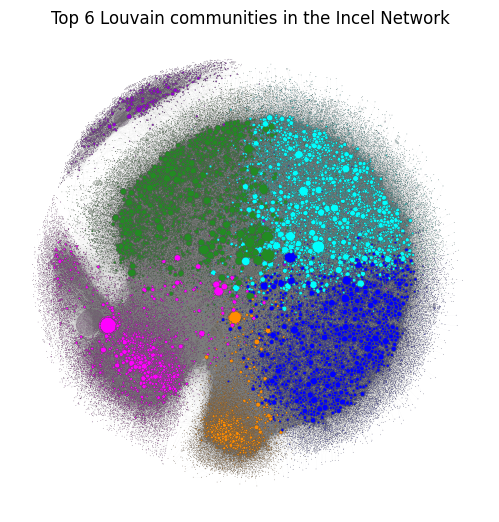

In [29]:
# ---- pick top-k communities by *real* ID ----
k = 6
top_comm_ids = [cid for cid, size in comm_sizes[:k]]  # e.g. [89, 129, 130, 191, 220, 188]

# Map community_id -> set of nodes
id2comm = {cid: louvain_comm[cid] for cid in top_comm_ids}

# --- 1) Subgraph with the k largest communities
nodes = set().union(*id2comm.values())
subgraph = G_All_communities.subgraph(nodes).copy()

# Assign the *real* community ID to each node
node2comm = {}
for cid, comm_nodes in id2comm.items():
    for n in comm_nodes:
        node2comm[n] = cid
nx.set_node_attributes(subgraph, node2comm, name="community")

# --- 2) Colors per community (now keyed by real ID)
colors = ['cyan', 'blue', 'forestgreen', 'magenta', 'darkorange', 'darkviolet']
comm_colors = {cid: colors[i % len(colors)] for i, cid in enumerate(top_comm_ids)}

# Attach the color to each node for netwulf
for n, cid in node2comm.items():
    subgraph.nodes[n]['color'] = comm_colors[cid]
    # optional: size etc.
    # subgraph.nodes[n]['size'] = 4 + 1.5 * subgraph.degree[n]

# --- 3) Small summary (keys are real community IDs)
community_length = {cid: len(id2comm[cid]) for cid in top_comm_ids}
print(f"The top-{k} communities and their assigned colors: {comm_colors}\n")
print(f"Number of nodes per community: {community_length}\n")
print(f"Total nodes in the top-{k} subgraph: {subgraph.number_of_nodes()}")

# --- 4) Plot with netwulf
title = f"Top {k} Louvain communities in the Incel Network"
network, config = visualize(subgraph)
fig, ax = draw_netwulf(network, config)
ax.set_title(title)


In [32]:
print_graph_info("Reddit - All Posts with Communities", G_All_communities)



########################################
Reddit - All Posts with Communities
----------------------------------------
Nodes: 84220
Edges: 1011470
Density: 0.000285
Directed: False
Connected: False
Amount of lonely nodes (degree 0): 0
########################################


In [13]:
# the highest edge weight in the graph
max_weight = max(data.get('weight', 1) for u, v, data in G_All_communities.edges(data=True))
print(f'\nThe highest edge weight in the graph is: {max_weight}')


The highest edge weight in the graph is: 838


# Centrality

**Degree centrality**

Degreee centrality simply tells how many edges each node in the network has. The assumption is that more central nodes work as hubs in the network and thus have a high degree

In [42]:
# Compute degree centrality
degree_centrality = nx.degree_centrality(G_All_communities)

# Sort by centrality descending
sorted_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Take top 15 nodes
top15_degree = sorted_degree[:15]

# Print top 15 authors by degree centrality
for idx, (node, degree) in enumerate(top15_degree):
    name = G_All_communities.nodes[node].get('label', 'Unknown')
    print(f"{idx+1}. Person with id: {name} — degree centrality: {round(degree, 4)} - Community: {G_All_communities.nodes[node]['community']} - Number of connections: {G_All_communities.degree[node]} - Number of posts: {G_All_communities.nodes[node]['n_posts']}")


1. Person with id: 924979690.842757 — degree centrality: 0.0884 - Community: 220 - Number of connections: 7447 - Number of posts: 48220
2. Person with id: 925121378.565168 — degree centrality: 0.0818 - Community: 130 - Number of connections: 6886 - Number of posts: 18131
3. Person with id: 924979745.996053 — degree centrality: 0.0714 - Community: 191 - Number of connections: 6012 - Number of posts: 104558
4. Person with id: 925779251.675878 — degree centrality: 0.0659 - Community: 130 - Number of connections: 5553 - Number of posts: 13412
5. Person with id: 925002509.041104 — degree centrality: 0.0546 - Community: 129 - Number of connections: 4599 - Number of posts: 13317
6. Person with id: 929912634.012361 — degree centrality: 0.0472 - Community: 89 - Number of connections: 3978 - Number of posts: 9025
7. Person with id: 931491396.579248 — degree centrality: 0.0465 - Community: 129 - Number of connections: 3920 - Number of posts: 6587
8. Person with id: 924990518.524643 — degree centr

**The closeness centrality**

Next we will look at closeness centrality, which tell us how "close" each node is to the other nodes in the network, meaning more central nodes have lower scores as they do not have to travel as far along the paths to get to other nodes in the network.
We still only consider the top 15 most central nodes, in networkx the centrality score is higher for more central nodes, meaning we consider the highest values in this case

In [55]:
centrality_of_G = nx.closeness_centrality(G_All_communities)
sorted_closeness = sorted(centrality_of_G.items(), key=lambda item: item[1], reverse=True)
top15_closeness = sorted_closeness[:15]
top15_closeness

[(27290, 0.46663661711280185),
 (20415, 0.4614056166487084),
 (19018, 0.4585699612351898),
 (4032, 0.45483792199942896),
 (75799, 0.4548354509405588),
 (16954, 0.45262967249030833),
 (54906, 0.4478620145979549),
 (69827, 0.44497221366824113),
 (78280, 0.44320547874399085),
 (73598, 0.4405003899525661),
 (20447, 0.4399355865098523),
 (90246, 0.43968836289015056),
 (84161, 0.43912333525389136),
 (66666, 0.43850462815942143),
 (15582, 0.4378510199095472)]

In [59]:
# Print top 15 authors by closeness centrality
for idx, (node, degree) in enumerate(top15_closeness):
    name = G_All_communities.nodes[node].get('label', 'Unknown')
    print(f"{idx+1}. Person with id: {name} — closeness centrality: {round(degree, 4)} - Community: {G_All_communities.nodes[node]['community']} - Number of connections: {G_All_communities.degree[node]} - Number of posts: {G_All_communities.nodes[node]['n_posts']}")


1. Person with id: 924979690.842757 — closeness centrality: 0.4666 - Community: 220 - Number of connections: 7447 - Number of posts: 48220
2. Person with id: 925121378.565168 — closeness centrality: 0.4614 - Community: 130 - Number of connections: 6886 - Number of posts: 18131
3. Person with id: 931491396.579248 — closeness centrality: 0.4586 - Community: 129 - Number of connections: 3920 - Number of posts: 6587
4. Person with id: 930904714.422173 — closeness centrality: 0.4548 - Community: 130 - Number of connections: 3321 - Number of posts: 6683
5. Person with id: 931591261.461143 — closeness centrality: 0.4548 - Community: 191 - Number of connections: 3265 - Number of posts: 6343
6. Person with id: 925779251.675878 — closeness centrality: 0.4526 - Community: 130 - Number of connections: 5553 - Number of posts: 13412
7. Person with id: 925002509.041104 — closeness centrality: 0.4479 - Community: 129 - Number of connections: 4599 - Number of posts: 13317
8. Person with id: 925218254.3

The nodes with the highest closeness centrality lie at the structural core of the incel network. They can reach other users in very few steps, indicating high connectivity across community boundaries. These users act as efficient “spreaders” of information, making them influential despite not necessarily having the highest degree or betweenness.

**Betweenness centrality**

This centrality measure tell us which nodes is most often in the shortest path between two arbitrary nodes in the network. Nodes with high betweenness centrality score are usually considered gatekeepers of information and is thus informative to examine in the context of bridging across comunities. We only use a subset of k=1000 random notes, otherwise it would take way too long to run. 

In [ ]:
between_centrality_of_G = nx.betweenness_centrality(G_All_communities, k=1000)
sorted_closeness_between = sorted(between_centrality_of_G.items(), key=lambda item: item[1], reverse=True)
top15_closeness_between = sorted_closeness_between[:15]
top15_closeness_between

In [61]:
# Print top 15 authors by closeness centrality
for idx, (node, degree) in enumerate(top15_closeness_between):
    name = G_All_communities.nodes[node].get('label', 'Unknown')
    print(f"{idx+1}. Person with id: {name} — betweeness centrality: {round(degree, 4)} - Community: {G_All_communities.nodes[node]['community']} - Number of connections: {G_All_communities.degree[node]} - Number of posts: {G_All_communities.nodes[node]['n_posts']}")


1. Person with id: 924979745.996053 — betweeness centrality: 0.087 - Community: 191 - Number of connections: 6012 - Number of posts: 104558
2. Person with id: 924979690.842757 — betweeness centrality: 0.0609 - Community: 220 - Number of connections: 7447 - Number of posts: 48220
3. Person with id: 925121378.565168 — betweeness centrality: 0.0479 - Community: 130 - Number of connections: 6886 - Number of posts: 18131
4. Person with id: 931491396.579248 — betweeness centrality: 0.0255 - Community: 129 - Number of connections: 3920 - Number of posts: 6587
5. Person with id: 925779251.675878 — betweeness centrality: 0.0247 - Community: 130 - Number of connections: 5553 - Number of posts: 13412
6. Person with id: 931591261.461143 — betweeness centrality: 0.0234 - Community: 191 - Number of connections: 3265 - Number of posts: 6343
7. Person with id: 930904714.422173 — betweeness centrality: 0.0194 - Community: 130 - Number of connections: 3321 - Number of posts: 6683
8. Person with id: 9299

Below we print out the communities our betweenness hubs bridge across. 

In [63]:
bridge_dict = dict()
for (node, val) in top15_closeness_between:
    bridge_dict[str(node)] = set()
    for (self, neighbour_node) in G_All_communities.edges(node):
        bridge_dict[str(self)].add(G_All_communities._node[neighbour_node]['community'])
betweenness_hubs = dict()
for node, bridges in bridge_dict.items():
    betweenness_hubs[G_All_communities._node[int(node)]['label']] = bridges
betweenness_hubs

{'924979745.996053': {89, 129, 130, 191, 220},
 '924979690.842757': {37,
  89,
  129,
  130,
  135,
  177,
  186,
  188,
  191,
  197,
  206,
  218,
  220},
 '925121378.565168': {20,
  89,
  126,
  129,
  130,
  150,
  186,
  188,
  191,
  197,
  206,
  218,
  220},
 '931491396.579248': {21, 89, 129, 130, 137, 188, 191, 197, 206, 220},
 '925779251.675878': {27,
  81,
  89,
  93,
  129,
  130,
  185,
  188,
  191,
  197,
  206,
  217,
  219,
  220},
 '931591261.461143': {89, 129, 130, 188, 191, 206, 220},
 '930904714.422173': {89, 129, 130, 188, 191, 197, 206, 220},
 '929912634.012361': {32, 35, 42, 89, 114, 129, 130, 188, 191, 201, 220},
 '925002509.041104': {89, 120, 129, 130, 146, 188, 191, 206, 220},
 '925218254.321411': {20, 81, 89, 129, 130, 188, 191, 197, 220},
 '927807536.758738': {89, 129, 130, 188, 191, 220},
 '925006802.224807': {129, 188, 191, 220},
 '924990518.524643': {35, 42, 67, 89, 93, 129, 130, 188, 191, 206, 219, 220},
 '925840698.841753': {89, 129, 130, 135, 191, 197

# Assortativity
Assortativity: A positive value indicates nodes with similar degrees are more likely to connect. This is common in social networks.
Disassortativity: A negative value indicates nodes with different degrees are more likely to connect, with high-degree nodes favoring low-degree neighbors. 

In [ ]:
def degree_assortativity(network):
    # Calculate degree assortativity
    num_edges = network.number_of_edges()
    degrees = dict(network.degree())

    kukv = sum(degrees[node1]*degrees[node2] for (node1, node2) in network.edges)  / num_edges
    kuv = [(degrees[node1], degrees[node2]) for (node1,node2) in network.edges] 
    ku = sum([ku[0] for ku in kuv]) / num_edges
    kv = sum([kv[1] for kv in kuv]) / num_edges 
 
    norm_term = np.sqrt(sum([ku[0]**2 for ku in kuv])/num_edges - ku**2)*np.sqrt(sum([kv[1]**2 for kv in kuv]) / num_edges - kv**2)
    return (kukv-ku*kv) / norm_term

print(f'The degree assortativity coefficient of the Incel-network using our own function: {degree_assortativity(G_All_communities)}')
print(f'The degree assortativity coefficient of the Incel-network using the networkx function: {nx.degree_assortativity_coefficient(G_All_communities)}')

The degree assortativity coefficient of the CSS-network using our own function: -0.1376699594851697
The degree assortativity coefficient of the CSS-network using the networkx function: -0.1348182192349422


The degree assortativity coefficient of –0.135 indicates that the incel network is disassortative. High-degree users tend to connect to low-degree users rather than to each other. This suggests a hub–periphery structure where a small group of central users interacts with many peripheral users.

This concludes the Network Analysis - the next notebook will focus on getting textual understanding of how the communities interact by looking at the words they use in their posts.